# Lesson 2: Chain-of-Thought and ReACT Prompting

## Demand‑Spike Detective for Retail Promotions

In this hands-on exercise, you will guide an LLM to explain an unexpected sales spike--probing promotions data, competitor-pricing changes, and weather shifts--and then recommend the right inventory response for the retail chain.
Outline:

- Setup
- Understand SKU‑level sales data, promotional calendars, etc. 
- Craft a CoT prompt that has the LLM hypothesize causes based on data provided.
- Create a ReACT prompt that can call a (simulated) weather‑API tool when the model suspects weather as a driver. 

## 1. Setup

Let's start by setting up the environment.

In [2]:
# Import necessary libraries
from openai import OpenAI
from IPython.display import Markdown, display
from enum import Enum
import os


In [3]:
# If using the Vocareum API endpoint
client = OpenAI(
    base_url="https://openai.vocareum.com/v1",
    api_key=os.getenv("OPENAI_API_KEY"),
)

# If using OpenAI's API endpoint
# client = OpenAI()


In [4]:
class OpenAIModels(str, Enum):
    GPT_4O_MINI = "gpt-4o-mini"
    GPT_41_MINI = "gpt-4.1-mini"
    GPT_41_NANO = "gpt-4.1-nano"


MODEL = OpenAIModels.GPT_41_MINI


def get_completion(system_prompt, user_prompt, model=MODEL):
    """
    Function to get a completion from the OpenAI API.
    Args:
        system_prompt: The system prompt
        user_prompt: The user prompt
        model: The model to use (default is gpt-4.1-mini)
    Returns:
        The completion text
    """
    try:
        response = client.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_prompt},
            ],
            temperature=0.7,
        )
        return response.choices[0].message.content
    except Exception as e:
        print(f"An error occurred: {e}")
        return None


def get_completion_messages(messages, model=MODEL, temperature=0.1):
    # Check that all messages are of the right form
    for message in messages:
        if (
            not isinstance(message, dict)
            or "role" not in message
            or "content" not in message
            or message["role"] not in ["system", "user", "assistant"]
        ):
            raise ValueError(f"Message is not valid: {message!r}")
    response = client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temperature,
    )
    return response.choices[0].message.content


def display_responses(*args):
    """Helper function to display responses as Markdown, horizontally."""
    markdown_string = "<table><tr>"
    # Headers
    for arg in args:
        markdown_string += f"<th>System Prompt:<br />{arg['system_prompt']}<br /><br />"
        markdown_string += f"User Prompt:<br />{arg['user_prompt']}</th>"
    markdown_string += "</tr>"
    # Rows
    markdown_string += "<tr>"
    for arg in args:
        markdown_string += f"<td>Response:<br />{arg['response']}</td>"
    markdown_string += "</tr></table>"
    display(Markdown(markdown_string))

## 2. Understand SKU-level sales data, promotional calendars, etc.

First, let's review the sample data provided. Working with AI Agents is still a data problem at its core, so the first steps are always to understand the business goals (explain the cause for the spike) and the underlying data.

In [5]:
from lesson_2_lib import (
    get_competitor_pricing_data,
    get_sales_data,
    get_promotions_data,
    get_weather_data,
)
import pandas as pd

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", None)

sales_data = get_sales_data()
sales_df = pd.DataFrame(sales_data)

promotions_data = get_promotions_data()
promotions_df = pd.DataFrame(promotions_data)

weather_data = get_weather_data()
weather_df = pd.DataFrame(weather_data)

competitor_pricing_data = get_competitor_pricing_data()
competitor_pricing_df = pd.DataFrame(competitor_pricing_data)


In [ ]:
sales_df.sort_values(by=["product_id", "date"], inplace=True)
sales_df


,date,product_id,product_name,quantity,revenue
0,2024-01-10,P001,Product 1,255,15547.35
5,2024-01-11,P001,Product 1,235,14327.95
10,2024-01-12,P001,Product 1,310,18900.70
15,2024-01-13,P001,Product 1,302,18412.94
20,2024-01-14,P001,Product 1,305,18595.85
25,2024-01-15,P001,Product 1,301,18351.97
30,2024-01-16,P001,Product 1,226,13779.22
1,2024-01-10,P002,Product 2,65,2297.10
6,2024-01-11,P002,Product 2,86,3039.24
11,2024-01-12,P002,Product 2,80,2827.20


In [10]:
promotions_df

,promotion_id,name,discount,products,start_date,end_date
0,PROMO001,Weekend Special,10% off,[P002],2024-01-12,2024-01-14
1,PROMO002,Flash Sale,15% off,"[P001, P003, P005]",2024-01-15,2024-01-16


In [11]:
weather_df.head()

,date,temperature,conditions
0,2024-01-10,"{'fahrenheit': 23.4, 'celsius': -4.8}","{'main': 'Clear', 'precipitation': 'None', 'precipitation_amount': 0, 'special_event': None}"
1,2024-01-11,"{'fahrenheit': 39.3, 'celsius': 4.1}","{'main': 'Clear', 'precipitation': 'None', 'precipitation_amount': 0, 'special_event': None}"
2,2024-01-12,"{'fahrenheit': 41.1, 'celsius': 5.1}","{'main': 'Heavy Rain', 'precipitation': 'Heavy Rain', 'precipitation_amount': 2.7, 'special_event': 'Flood Warning'}"
3,2024-01-13,"{'fahrenheit': 27.2, 'celsius': -2.6}","{'main': 'Clear', 'precipitation': 'None', 'precipitation_amount': 0, 'special_event': None}"
4,2024-01-14,"{'fahrenheit': 22.9, 'celsius': -5.1}","{'main': 'Clear', 'precipitation': 'None', 'precipitation_amount': 0, 'special_event': None}"


In [12]:
competitor_pricing_df.head()

,product,date,our_price,competitor_sales,competitor_a_price,competitor_b_price,competitor_c_price
0,Product 1,2024-01-10,60.97,{},56.88,62.23,51.80
1,Product 1,2024-01-11,60.97,{},59.65,72.47,72.50
2,Product 1,2024-01-12,60.97,"{'CompetitorB': {'original_price': 69.24, 'sale_price': 50.55, 'discount_percentage': 27}, 'CompetitorC': {'original_price': 49.92, 'sale_price': 39.44, 'discount_percentage': 21}}",65.40,50.55,39.44
3,Product 1,2024-01-13,60.97,{},72.13,57.54,51.10
4,Product 1,2024-01-14,60.97,{},72.36,70.04,61.04


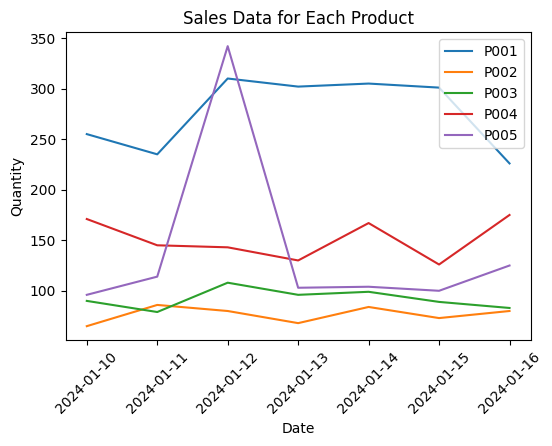

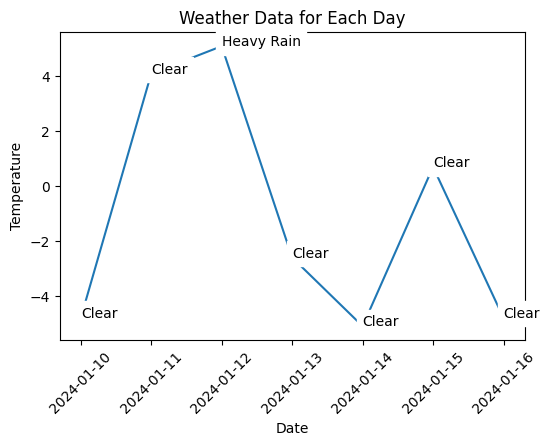

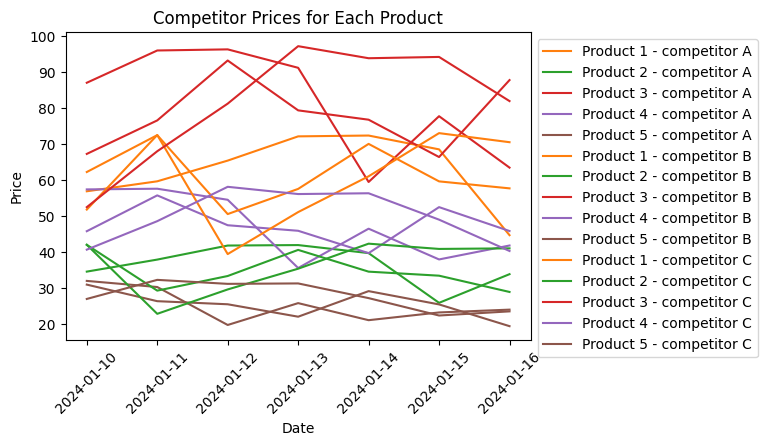

In [16]:
# Graph the sales data
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
for product_id, product_data in sales_df.groupby("product_id"):
    product_data.sort_values(by="date", inplace=True)
    plt.plot(product_data["date"], product_data["quantity"], label=product_id)
plt.xlabel("Date")
plt.ylabel("Quantity")
plt.title("Sales Data for Each Product")
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Plot the weather data

weather_df["temperature_c"] = weather_df["temperature"].apply(lambda x: x["celsius"])


plt.figure(figsize=(6, 4))
plt.plot(weather_df["date"], weather_df["temperature_c"])

# For each day, add the value of "main" in text
for i, row in weather_df.iterrows():
    # Add a transparent background to the text
    plt.text(
        row["date"],
        row["temperature_c"],
        row["conditions"]["main"],
        backgroundcolor="white",
    )


plt.xlabel("Date")
plt.xticks(rotation=45)
plt.ylabel("Temperature")
plt.title("Weather Data for Each Day")
plt.show()

# Plot the competitor pricing data

plt.figure(figsize=(6, 4))
for competitor in ["a", "b", "c"]:
    for product in competitor_pricing_df["product"].unique():
        plt.plot(
            competitor_pricing_df[competitor_pricing_df["product"] == product]["date"],
            competitor_pricing_df[competitor_pricing_df["product"] == product][
                f"competitor_{competitor}_price"
            ],
            label=f"{product} - competitor {competitor.upper()}",
            color=f"C{product[-1]}",
        )
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.ylabel("Price")
plt.title("Competitor Prices for Each Product")
# Put the legend outside the plot
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.show()

### Reflect on the sales data

`TODO: Insert your reflection here`

Reflection: The sales data shows a clear pattern of sales spikes for Product 5 on January 12th, which is the same day as a promotion. There was a promotion, "Weekend Special", which started on January 12th, but that was for Product 2.

Looking ahead we see that the weather was fluctuating between below freezing and above freezing. On the 12th in particular, there was heavy rain.

Competitor pricing is a bit harder to look at, but if we isolate it to Product 5, we see that the price for one competitor dropped on January 12th, for whatever reason.

In practice, a human would look at all these factors and more to determine the cause of the sales spike. They would also dig deeper, looking at more data to understand the root cause. 

For one, they would want to understand what the products are and who is buying them.

Let's see if we can get this far with a CoT prompt, which should at least find the sales spike and not assume this promotion is responsible.

## 2. Craft a simple CoT prompt

Let's start with a simple CoT prompt. We won't tell the model to which steps to follow. We also won't use any tools in this example.


In [17]:
system_prompt_cot = """
You are a meticulous Retail Demand Analyst.
Your task is to analyze provided sales data and promotion schedules to identify and explain significant sales spikes for specific SKUs.

"""
# TODO: Fill in the part marked with ********** with a phrase such as "Think step by step."
# Feel free to try variations!
user_prompt_analyze = f"""
Analyze the data provided below and hypothesize causes for any observed sales spikes.

Think step by step.

Sales Data:
{sales_data}

Promotions Calendar:
{promotions_data}

Weather Data:
{weather_data}

Competitor Pricing Data:
{competitor_pricing_data}
"""

print(f"Sending prompt to {MODEL} model...")
cot_response_1 = get_completion(system_prompt_cot, user_prompt_analyze)
cot_response_2 = get_completion(system_prompt_cot, user_prompt_analyze)
print("Response received!\n")

# We compare two of runs of the same prompts
# This may take up to a minute
display_responses(
    {
        "system_prompt": system_prompt_cot,
        "user_prompt": user_prompt_analyze,
        "response": cot_response_1,
    },
    {
        "system_prompt": system_prompt_cot,
        "user_prompt": user_prompt_analyze,
        "response": cot_response_2,
    },
)


Sending prompt to OpenAIModels.GPT_41_MINI model...
Response received!



<table><tr><th>System Prompt:<br />
You are a meticulous Retail Demand Analyst.
Your task is to analyze provided sales data and promotion schedules to identify and explain significant sales spikes for specific SKUs.

<br /><br />User Prompt:<br />
Analyze the data provided below and hypothesize causes for any observed sales spikes.

Think step by step.

Sales Data:
[{'date': datetime.date(2024, 1, 10), 'product_id': 'P001', 'product_name': 'Product 1', 'quantity': 255, 'revenue': 15547.35}, {'date': datetime.date(2024, 1, 10), 'product_id': 'P002', 'product_name': 'Product 2', 'quantity': 65, 'revenue': 2297.1}, {'date': datetime.date(2024, 1, 10), 'product_id': 'P003', 'product_name': 'Product 3', 'quantity': 90, 'revenue': 7301.7}, {'date': datetime.date(2024, 1, 10), 'product_id': 'P004', 'product_name': 'Product 4', 'quantity': 171, 'revenue': 8296.92}, {'date': datetime.date(2024, 1, 10), 'product_id': 'P005', 'product_name': 'Product 5', 'quantity': 96, 'revenue': 2587.2}, {'date': datetime.date(2024, 1, 11), 'product_id': 'P001', 'product_name': 'Product 1', 'quantity': 235, 'revenue': 14327.95}, {'date': datetime.date(2024, 1, 11), 'product_id': 'P002', 'product_name': 'Product 2', 'quantity': 86, 'revenue': 3039.24}, {'date': datetime.date(2024, 1, 11), 'product_id': 'P003', 'product_name': 'Product 3', 'quantity': 79, 'revenue': 6409.27}, {'date': datetime.date(2024, 1, 11), 'product_id': 'P004', 'product_name': 'Product 4', 'quantity': 145, 'revenue': 7035.4}, {'date': datetime.date(2024, 1, 11), 'product_id': 'P005', 'product_name': 'Product 5', 'quantity': 114, 'revenue': 3072.3}, {'date': datetime.date(2024, 1, 12), 'product_id': 'P001', 'product_name': 'Product 1', 'quantity': 310, 'revenue': 18900.7}, {'date': datetime.date(2024, 1, 12), 'product_id': 'P002', 'product_name': 'Product 2', 'quantity': 80, 'revenue': 2827.2}, {'date': datetime.date(2024, 1, 12), 'product_id': 'P003', 'product_name': 'Product 3', 'quantity': 108, 'revenue': 8762.04}, {'date': datetime.date(2024, 1, 12), 'product_id': 'P004', 'product_name': 'Product 4', 'quantity': 143, 'revenue': 6938.36}, {'date': datetime.date(2024, 1, 12), 'product_id': 'P005', 'product_name': 'Product 5', 'quantity': 342, 'revenue': 9216.9}, {'date': datetime.date(2024, 1, 13), 'product_id': 'P001', 'product_name': 'Product 1', 'quantity': 302, 'revenue': 18412.94}, {'date': datetime.date(2024, 1, 13), 'product_id': 'P002', 'product_name': 'Product 2', 'quantity': 68, 'revenue': 2403.12}, {'date': datetime.date(2024, 1, 13), 'product_id': 'P003', 'product_name': 'Product 3', 'quantity': 96, 'revenue': 7788.48}, {'date': datetime.date(2024, 1, 13), 'product_id': 'P004', 'product_name': 'Product 4', 'quantity': 130, 'revenue': 6307.6}, {'date': datetime.date(2024, 1, 13), 'product_id': 'P005', 'product_name': 'Product 5', 'quantity': 103, 'revenue': 2775.85}, {'date': datetime.date(2024, 1, 14), 'product_id': 'P001', 'product_name': 'Product 1', 'quantity': 305, 'revenue': 18595.85}, {'date': datetime.date(2024, 1, 14), 'product_id': 'P002', 'product_name': 'Product 2', 'quantity': 84, 'revenue': 2968.56}, {'date': datetime.date(2024, 1, 14), 'product_id': 'P003', 'product_name': 'Product 3', 'quantity': 99, 'revenue': 8031.87}, {'date': datetime.date(2024, 1, 14), 'product_id': 'P004', 'product_name': 'Product 4', 'quantity': 167, 'revenue': 8102.84}, {'date': datetime.date(2024, 1, 14), 'product_id': 'P005', 'product_name': 'Product 5', 'quantity': 104, 'revenue': 2802.8}, {'date': datetime.date(2024, 1, 15), 'product_id': 'P001', 'product_name': 'Product 1', 'quantity': 301, 'revenue': 18351.97}, {'date': datetime.date(2024, 1, 15), 'product_id': 'P002', 'product_name': 'Product 2', 'quantity': 73, 'revenue': 2579.82}, {'date': datetime.date(2024, 1, 15), 'product_id': 'P003', 'product_name': 'Product 3', 'quantity': 89, 'revenue': 7220.57}, {'date': datetime.date(2024, 1, 15), 'product_id': 'P004', 'product_name': 'Product 4', 'quantity': 126, 'revenue': 6113.52}, {'date': datetime.date(2024, 1, 15), 'product_id': 'P005', 'product_name': 'Product 5', 'quantity': 100, 'revenue': 2695.0}, {'date': datetime.date(2024, 1, 16), 'product_id': 'P001', 'product_name': 'Product 1', 'quantity': 226, 'revenue': 13779.22}, {'date': datetime.date(2024, 1, 16), 'product_id': 'P002', 'product_name': 'Product 2', 'quantity': 80, 'revenue': 2827.2}, {'date': datetime.date(2024, 1, 16), 'product_id': 'P003', 'product_name': 'Product 3', 'quantity': 83, 'revenue': 6733.79}, {'date': datetime.date(2024, 1, 16), 'product_id': 'P004', 'product_name': 'Product 4', 'quantity': 175, 'revenue': 8491.0}, {'date': datetime.date(2024, 1, 16), 'product_id': 'P005', 'product_name': 'Product 5', 'quantity': 125, 'revenue': 3368.75}]

Promotions Calendar:
[{'promotion_id': 'PROMO001', 'name': 'Weekend Special', 'discount': '10% off', 'products': ['P002'], 'start_date': datetime.date(2024, 1, 12), 'end_date': datetime.date(2024, 1, 14)}, {'promotion_id': 'PROMO002', 'name': 'Flash Sale', 'discount': '15% off', 'products': ['P001', 'P003', 'P005'], 'start_date': datetime.date(2024, 1, 15), 'end_date': datetime.date(2024, 1, 16)}]

Weather Data:
[{'date': '2024-01-10', 'temperature': {'fahrenheit': 23.4, 'celsius': -4.8}, 'conditions': {'main': 'Clear', 'precipitation': 'None', 'precipitation_amount': 0, 'special_event': None}}, {'date': '2024-01-11', 'temperature': {'fahrenheit': 39.3, 'celsius': 4.1}, 'conditions': {'main': 'Clear', 'precipitation': 'None', 'precipitation_amount': 0, 'special_event': None}}, {'date': '2024-01-12', 'temperature': {'fahrenheit': 41.1, 'celsius': 5.1}, 'conditions': {'main': 'Heavy Rain', 'precipitation': 'Heavy Rain', 'precipitation_amount': 2.7, 'special_event': 'Flood Warning'}}, {'date': '2024-01-13', 'temperature': {'fahrenheit': 27.2, 'celsius': -2.6}, 'conditions': {'main': 'Clear', 'precipitation': 'None', 'precipitation_amount': 0, 'special_event': None}}, {'date': '2024-01-14', 'temperature': {'fahrenheit': 22.9, 'celsius': -5.1}, 'conditions': {'main': 'Clear', 'precipitation': 'None', 'precipitation_amount': 0, 'special_event': None}}, {'date': '2024-01-15', 'temperature': {'fahrenheit': 33.2, 'celsius': 0.7}, 'conditions': {'main': 'Clear', 'precipitation': 'None', 'precipitation_amount': 0, 'special_event': 'High Winds'}}, {'date': '2024-01-16', 'temperature': {'fahrenheit': 23.3, 'celsius': -4.8}, 'conditions': {'main': 'Clear', 'precipitation': 'None', 'precipitation_amount': 0, 'special_event': None}}]

Competitor Pricing Data:
[{'product': 'Product 1', 'date': '2024-01-10', 'our_price': 60.97, 'competitor_sales': {}, 'competitor_a_price': 56.88, 'competitor_b_price': 62.23, 'competitor_c_price': 51.8}, {'product': 'Product 1', 'date': '2024-01-11', 'our_price': 60.97, 'competitor_sales': {}, 'competitor_a_price': 59.65, 'competitor_b_price': 72.47, 'competitor_c_price': 72.5}, {'product': 'Product 1', 'date': '2024-01-12', 'our_price': 60.97, 'competitor_sales': {'CompetitorB': {'original_price': 69.24, 'sale_price': 50.55, 'discount_percentage': 27}, 'CompetitorC': {'original_price': 49.92, 'sale_price': 39.44, 'discount_percentage': 21}}, 'competitor_a_price': 65.4, 'competitor_b_price': 50.55, 'competitor_c_price': 39.44}, {'product': 'Product 1', 'date': '2024-01-13', 'our_price': 60.97, 'competitor_sales': {}, 'competitor_a_price': 72.13, 'competitor_b_price': 57.54, 'competitor_c_price': 51.1}, {'product': 'Product 1', 'date': '2024-01-14', 'our_price': 60.97, 'competitor_sales': {}, 'competitor_a_price': 72.36, 'competitor_b_price': 70.04, 'competitor_c_price': 61.04}, {'product': 'Product 1', 'date': '2024-01-15', 'our_price': 60.97, 'competitor_sales': {}, 'competitor_a_price': 68.52, 'competitor_b_price': 59.63, 'competitor_c_price': 73.03}, {'product': 'Product 1', 'date': '2024-01-16', 'our_price': 60.97, 'competitor_sales': {'CompetitorA': {'original_price': 53.84, 'sale_price': 44.69, 'discount_percentage': 17}}, 'competitor_a_price': 44.69, 'competitor_b_price': 57.69, 'competitor_c_price': 70.51}, {'product': 'Product 2', 'date': '2024-01-10', 'our_price': 35.34, 'competitor_sales': {}, 'competitor_a_price': 34.57, 'competitor_b_price': 42.01, 'competitor_c_price': 42.02}, {'product': 'Product 2', 'date': '2024-01-11', 'our_price': 35.34, 'competitor_sales': {'CompetitorB': {'original_price': 40.13, 'sale_price': 29.29, 'discount_percentage': 27}, 'CompetitorC': {'original_price': 28.93, 'sale_price': 22.85, 'discount_percentage': 21}}, 'competitor_a_price': 37.91, 'competitor_b_price': 29.29, 'competitor_c_price': 22.85}, {'product': 'Product 2', 'date': '2024-01-12', 'our_price': 35.34, 'competitor_sales': {}, 'competitor_a_price': 41.81, 'competitor_b_price': 33.35, 'competitor_c_price': 29.62}, {'product': 'Product 2', 'date': '2024-01-13', 'our_price': 35.34, 'competitor_sales': {}, 'competitor_a_price': 41.94, 'competitor_b_price': 40.6, 'competitor_c_price': 35.38}, {'product': 'Product 2', 'date': '2024-01-14', 'our_price': 35.34, 'competitor_sales': {}, 'competitor_a_price': 39.71, 'competitor_b_price': 34.56, 'competitor_c_price': 42.33}, {'product': 'Product 2', 'date': '2024-01-15', 'our_price': 35.34, 'competitor_sales': {'CompetitorA': {'original_price': 31.21, 'sale_price': 25.9, 'discount_percentage': 17}}, 'competitor_a_price': 25.9, 'competitor_b_price': 33.44, 'competitor_c_price': 40.87}, {'product': 'Product 2', 'date': '2024-01-16', 'our_price': 35.34, 'competitor_sales': {}, 'competitor_a_price': 33.86, 'competitor_b_price': 28.92, 'competitor_c_price': 41.03}, {'product': 'Product 3', 'date': '2024-01-10', 'our_price': 81.13, 'competitor_sales': {'CompetitorB': {'original_price': 92.14, 'sale_price': 67.26, 'discount_percentage': 27}, 'CompetitorC': {'original_price': 66.42, 'sale_price': 52.47, 'discount_percentage': 21}}, 'competitor_a_price': 87.02, 'competitor_b_price': 67.26, 'competitor_c_price': 52.47}, {'product': 'Product 3', 'date': '2024-01-11', 'our_price': 81.13, 'competitor_sales': {}, 'competitor_a_price': 95.98, 'competitor_b_price': 76.56, 'competitor_c_price': 68.0}, {'product': 'Product 3', 'date': '2024-01-12', 'our_price': 81.13, 'competitor_sales': {}, 'competitor_a_price': 96.29, 'competitor_b_price': 93.2, 'competitor_c_price': 81.22}, {'product': 'Product 3', 'date': '2024-01-13', 'our_price': 81.13, 'competitor_sales': {}, 'competitor_a_price': 91.17, 'competitor_b_price': 79.35, 'competitor_c_price': 97.18}, {'product': 'Product 3', 'date': '2024-01-14', 'our_price': 81.13, 'competitor_sales': {'CompetitorA': {'original_price': 71.64, 'sale_price': 59.46, 'discount_percentage': 17}}, 'competitor_a_price': 59.46, 'competitor_b_price': 76.76, 'competitor_c_price': 93.83}, {'product': 'Product 3', 'date': '2024-01-15', 'our_price': 81.13, 'competitor_sales': {}, 'competitor_a_price': 77.73, 'competitor_b_price': 66.39, 'competitor_c_price': 94.19}, {'product': 'Product 3', 'date': '2024-01-16', 'our_price': 81.13, 'competitor_sales': {'CompetitorA': {'original_price': 80.32, 'sale_price': 63.45, 'discount_percentage': 21}}, 'competitor_a_price': 63.45, 'competitor_b_price': 87.76, 'competitor_c_price': 81.93}, {'product': 'Product 4', 'date': '2024-01-10', 'our_price': 48.52, 'competitor_sales': {}, 'competitor_a_price': 57.4, 'competitor_b_price': 45.79, 'competitor_c_price': 40.67}, {'product': 'Product 4', 'date': '2024-01-11', 'our_price': 48.52, 'competitor_sales': {}, 'competitor_a_price': 57.59, 'competitor_b_price': 55.74, 'competitor_c_price': 48.58}, {'product': 'Product 4', 'date': '2024-01-12', 'our_price': 48.52, 'competitor_sales': {}, 'competitor_a_price': 54.52, 'competitor_b_price': 47.45, 'competitor_c_price': 58.12}, {'product': 'Product 4', 'date': '2024-01-13', 'our_price': 48.52, 'competitor_sales': {'CompetitorA': {'original_price': 42.85, 'sale_price': 35.57, 'discount_percentage': 17}}, 'competitor_a_price': 35.57, 'competitor_b_price': 45.91, 'competitor_c_price': 56.11}, {'product': 'Product 4', 'date': '2024-01-14', 'our_price': 48.52, 'competitor_sales': {}, 'competitor_a_price': 46.49, 'competitor_b_price': 39.7, 'competitor_c_price': 56.33}, {'product': 'Product 4', 'date': '2024-01-15', 'our_price': 48.52, 'competitor_sales': {'CompetitorA': {'original_price': 48.04, 'sale_price': 37.95, 'discount_percentage': 21}}, 'competitor_a_price': 37.95, 'competitor_b_price': 52.48, 'competitor_c_price': 49.0}, {'product': 'Product 4', 'date': '2024-01-16', 'our_price': 48.52, 'competitor_sales': {'CompetitorB': {'original_price': 50.93, 'sale_price': 45.84, 'discount_percentage': 10}, 'CompetitorC': {'original_price': 51.01, 'sale_price': 40.3, 'discount_percentage': 21}}, 'competitor_a_price': 41.82, 'competitor_b_price': 45.84, 'competitor_c_price': 40.3}, {'product': 'Product 5', 'date': '2024-01-10', 'our_price': 26.95, 'competitor_sales': {}, 'competitor_a_price': 31.99, 'competitor_b_price': 30.96, 'competitor_c_price': 26.98}, {'product': 'Product 5', 'date': '2024-01-11', 'our_price': 26.95, 'competitor_sales': {}, 'competitor_a_price': 30.29, 'competitor_b_price': 26.36, 'competitor_c_price': 32.28}, {'product': 'Product 5', 'date': '2024-01-12', 'our_price': 26.95, 'competitor_sales': {'CompetitorA': {'original_price': 23.8, 'sale_price': 19.75, 'discount_percentage': 17}}, 'competitor_a_price': 19.75, 'competitor_b_price': 25.5, 'competitor_c_price': 31.17}, {'product': 'Product 5', 'date': '2024-01-13', 'our_price': 26.95, 'competitor_sales': {}, 'competitor_a_price': 25.82, 'competitor_b_price': 22.05, 'competitor_c_price': 31.29}, {'product': 'Product 5', 'date': '2024-01-14', 'our_price': 26.95, 'competitor_sales': {'CompetitorA': {'original_price': 26.68, 'sale_price': 21.08, 'discount_percentage': 21}}, 'competitor_a_price': 21.08, 'competitor_b_price': 29.15, 'competitor_c_price': 27.21}, {'product': 'Product 5', 'date': '2024-01-15', 'our_price': 26.95, 'competitor_sales': {'CompetitorB': {'original_price': 28.29, 'sale_price': 25.46, 'discount_percentage': 10}, 'CompetitorC': {'original_price': 28.33, 'sale_price': 22.38, 'discount_percentage': 21}}, 'competitor_a_price': 23.23, 'competitor_b_price': 25.46, 'competitor_c_price': 22.38}, {'product': 'Product 5', 'date': '2024-01-16', 'our_price': 26.95, 'competitor_sales': {'CompetitorA': {'original_price': 27.28, 'sale_price': 24.01, 'discount_percentage': 12}, 'CompetitorB': {'original_price': 24.9, 'sale_price': 19.42, 'discount_percentage': 22}, 'CompetitorC': {'original_price': 30.56, 'sale_price': 23.53, 'discount_percentage': 23}}, 'competitor_a_price': 24.01, 'competitor_b_price': 19.42, 'competitor_c_price': 23.53}]
</th><th>System Prompt:<br />
You are a meticulous Retail Demand Analyst.
Your task is to analyze provided sales data and promotion schedules to identify and explain significant sales spikes for specific SKUs.

<br /><br />User Prompt:<br />
Analyze the data provided below and hypothesize causes for any observed sales spikes.

Think step by step.

Sales Data:
[{'date': datetime.date(2024, 1, 10), 'product_id': 'P001', 'product_name': 'Product 1', 'quantity': 255, 'revenue': 15547.35}, {'date': datetime.date(2024, 1, 10), 'product_id': 'P002', 'product_name': 'Product 2', 'quantity': 65, 'revenue': 2297.1}, {'date': datetime.date(2024, 1, 10), 'product_id': 'P003', 'product_name': 'Product 3', 'quantity': 90, 'revenue': 7301.7}, {'date': datetime.date(2024, 1, 10), 'product_id': 'P004', 'product_name': 'Product 4', 'quantity': 171, 'revenue': 8296.92}, {'date': datetime.date(2024, 1, 10), 'product_id': 'P005', 'product_name': 'Product 5', 'quantity': 96, 'revenue': 2587.2}, {'date': datetime.date(2024, 1, 11), 'product_id': 'P001', 'product_name': 'Product 1', 'quantity': 235, 'revenue': 14327.95}, {'date': datetime.date(2024, 1, 11), 'product_id': 'P002', 'product_name': 'Product 2', 'quantity': 86, 'revenue': 3039.24}, {'date': datetime.date(2024, 1, 11), 'product_id': 'P003', 'product_name': 'Product 3', 'quantity': 79, 'revenue': 6409.27}, {'date': datetime.date(2024, 1, 11), 'product_id': 'P004', 'product_name': 'Product 4', 'quantity': 145, 'revenue': 7035.4}, {'date': datetime.date(2024, 1, 11), 'product_id': 'P005', 'product_name': 'Product 5', 'quantity': 114, 'revenue': 3072.3}, {'date': datetime.date(2024, 1, 12), 'product_id': 'P001', 'product_name': 'Product 1', 'quantity': 310, 'revenue': 18900.7}, {'date': datetime.date(2024, 1, 12), 'product_id': 'P002', 'product_name': 'Product 2', 'quantity': 80, 'revenue': 2827.2}, {'date': datetime.date(2024, 1, 12), 'product_id': 'P003', 'product_name': 'Product 3', 'quantity': 108, 'revenue': 8762.04}, {'date': datetime.date(2024, 1, 12), 'product_id': 'P004', 'product_name': 'Product 4', 'quantity': 143, 'revenue': 6938.36}, {'date': datetime.date(2024, 1, 12), 'product_id': 'P005', 'product_name': 'Product 5', 'quantity': 342, 'revenue': 9216.9}, {'date': datetime.date(2024, 1, 13), 'product_id': 'P001', 'product_name': 'Product 1', 'quantity': 302, 'revenue': 18412.94}, {'date': datetime.date(2024, 1, 13), 'product_id': 'P002', 'product_name': 'Product 2', 'quantity': 68, 'revenue': 2403.12}, {'date': datetime.date(2024, 1, 13), 'product_id': 'P003', 'product_name': 'Product 3', 'quantity': 96, 'revenue': 7788.48}, {'date': datetime.date(2024, 1, 13), 'product_id': 'P004', 'product_name': 'Product 4', 'quantity': 130, 'revenue': 6307.6}, {'date': datetime.date(2024, 1, 13), 'product_id': 'P005', 'product_name': 'Product 5', 'quantity': 103, 'revenue': 2775.85}, {'date': datetime.date(2024, 1, 14), 'product_id': 'P001', 'product_name': 'Product 1', 'quantity': 305, 'revenue': 18595.85}, {'date': datetime.date(2024, 1, 14), 'product_id': 'P002', 'product_name': 'Product 2', 'quantity': 84, 'revenue': 2968.56}, {'date': datetime.date(2024, 1, 14), 'product_id': 'P003', 'product_name': 'Product 3', 'quantity': 99, 'revenue': 8031.87}, {'date': datetime.date(2024, 1, 14), 'product_id': 'P004', 'product_name': 'Product 4', 'quantity': 167, 'revenue': 8102.84}, {'date': datetime.date(2024, 1, 14), 'product_id': 'P005', 'product_name': 'Product 5', 'quantity': 104, 'revenue': 2802.8}, {'date': datetime.date(2024, 1, 15), 'product_id': 'P001', 'product_name': 'Product 1', 'quantity': 301, 'revenue': 18351.97}, {'date': datetime.date(2024, 1, 15), 'product_id': 'P002', 'product_name': 'Product 2', 'quantity': 73, 'revenue': 2579.82}, {'date': datetime.date(2024, 1, 15), 'product_id': 'P003', 'product_name': 'Product 3', 'quantity': 89, 'revenue': 7220.57}, {'date': datetime.date(2024, 1, 15), 'product_id': 'P004', 'product_name': 'Product 4', 'quantity': 126, 'revenue': 6113.52}, {'date': datetime.date(2024, 1, 15), 'product_id': 'P005', 'product_name': 'Product 5', 'quantity': 100, 'revenue': 2695.0}, {'date': datetime.date(2024, 1, 16), 'product_id': 'P001', 'product_name': 'Product 1', 'quantity': 226, 'revenue': 13779.22}, {'date': datetime.date(2024, 1, 16), 'product_id': 'P002', 'product_name': 'Product 2', 'quantity': 80, 'revenue': 2827.2}, {'date': datetime.date(2024, 1, 16), 'product_id': 'P003', 'product_name': 'Product 3', 'quantity': 83, 'revenue': 6733.79}, {'date': datetime.date(2024, 1, 16), 'product_id': 'P004', 'product_name': 'Product 4', 'quantity': 175, 'revenue': 8491.0}, {'date': datetime.date(2024, 1, 16), 'product_id': 'P005', 'product_name': 'Product 5', 'quantity': 125, 'revenue': 3368.75}]

Promotions Calendar:
[{'promotion_id': 'PROMO001', 'name': 'Weekend Special', 'discount': '10% off', 'products': ['P002'], 'start_date': datetime.date(2024, 1, 12), 'end_date': datetime.date(2024, 1, 14)}, {'promotion_id': 'PROMO002', 'name': 'Flash Sale', 'discount': '15% off', 'products': ['P001', 'P003', 'P005'], 'start_date': datetime.date(2024, 1, 15), 'end_date': datetime.date(2024, 1, 16)}]

Weather Data:
[{'date': '2024-01-10', 'temperature': {'fahrenheit': 23.4, 'celsius': -4.8}, 'conditions': {'main': 'Clear', 'precipitation': 'None', 'precipitation_amount': 0, 'special_event': None}}, {'date': '2024-01-11', 'temperature': {'fahrenheit': 39.3, 'celsius': 4.1}, 'conditions': {'main': 'Clear', 'precipitation': 'None', 'precipitation_amount': 0, 'special_event': None}}, {'date': '2024-01-12', 'temperature': {'fahrenheit': 41.1, 'celsius': 5.1}, 'conditions': {'main': 'Heavy Rain', 'precipitation': 'Heavy Rain', 'precipitation_amount': 2.7, 'special_event': 'Flood Warning'}}, {'date': '2024-01-13', 'temperature': {'fahrenheit': 27.2, 'celsius': -2.6}, 'conditions': {'main': 'Clear', 'precipitation': 'None', 'precipitation_amount': 0, 'special_event': None}}, {'date': '2024-01-14', 'temperature': {'fahrenheit': 22.9, 'celsius': -5.1}, 'conditions': {'main': 'Clear', 'precipitation': 'None', 'precipitation_amount': 0, 'special_event': None}}, {'date': '2024-01-15', 'temperature': {'fahrenheit': 33.2, 'celsius': 0.7}, 'conditions': {'main': 'Clear', 'precipitation': 'None', 'precipitation_amount': 0, 'special_event': 'High Winds'}}, {'date': '2024-01-16', 'temperature': {'fahrenheit': 23.3, 'celsius': -4.8}, 'conditions': {'main': 'Clear', 'precipitation': 'None', 'precipitation_amount': 0, 'special_event': None}}]

Competitor Pricing Data:
[{'product': 'Product 1', 'date': '2024-01-10', 'our_price': 60.97, 'competitor_sales': {}, 'competitor_a_price': 56.88, 'competitor_b_price': 62.23, 'competitor_c_price': 51.8}, {'product': 'Product 1', 'date': '2024-01-11', 'our_price': 60.97, 'competitor_sales': {}, 'competitor_a_price': 59.65, 'competitor_b_price': 72.47, 'competitor_c_price': 72.5}, {'product': 'Product 1', 'date': '2024-01-12', 'our_price': 60.97, 'competitor_sales': {'CompetitorB': {'original_price': 69.24, 'sale_price': 50.55, 'discount_percentage': 27}, 'CompetitorC': {'original_price': 49.92, 'sale_price': 39.44, 'discount_percentage': 21}}, 'competitor_a_price': 65.4, 'competitor_b_price': 50.55, 'competitor_c_price': 39.44}, {'product': 'Product 1', 'date': '2024-01-13', 'our_price': 60.97, 'competitor_sales': {}, 'competitor_a_price': 72.13, 'competitor_b_price': 57.54, 'competitor_c_price': 51.1}, {'product': 'Product 1', 'date': '2024-01-14', 'our_price': 60.97, 'competitor_sales': {}, 'competitor_a_price': 72.36, 'competitor_b_price': 70.04, 'competitor_c_price': 61.04}, {'product': 'Product 1', 'date': '2024-01-15', 'our_price': 60.97, 'competitor_sales': {}, 'competitor_a_price': 68.52, 'competitor_b_price': 59.63, 'competitor_c_price': 73.03}, {'product': 'Product 1', 'date': '2024-01-16', 'our_price': 60.97, 'competitor_sales': {'CompetitorA': {'original_price': 53.84, 'sale_price': 44.69, 'discount_percentage': 17}}, 'competitor_a_price': 44.69, 'competitor_b_price': 57.69, 'competitor_c_price': 70.51}, {'product': 'Product 2', 'date': '2024-01-10', 'our_price': 35.34, 'competitor_sales': {}, 'competitor_a_price': 34.57, 'competitor_b_price': 42.01, 'competitor_c_price': 42.02}, {'product': 'Product 2', 'date': '2024-01-11', 'our_price': 35.34, 'competitor_sales': {'CompetitorB': {'original_price': 40.13, 'sale_price': 29.29, 'discount_percentage': 27}, 'CompetitorC': {'original_price': 28.93, 'sale_price': 22.85, 'discount_percentage': 21}}, 'competitor_a_price': 37.91, 'competitor_b_price': 29.29, 'competitor_c_price': 22.85}, {'product': 'Product 2', 'date': '2024-01-12', 'our_price': 35.34, 'competitor_sales': {}, 'competitor_a_price': 41.81, 'competitor_b_price': 33.35, 'competitor_c_price': 29.62}, {'product': 'Product 2', 'date': '2024-01-13', 'our_price': 35.34, 'competitor_sales': {}, 'competitor_a_price': 41.94, 'competitor_b_price': 40.6, 'competitor_c_price': 35.38}, {'product': 'Product 2', 'date': '2024-01-14', 'our_price': 35.34, 'competitor_sales': {}, 'competitor_a_price': 39.71, 'competitor_b_price': 34.56, 'competitor_c_price': 42.33}, {'product': 'Product 2', 'date': '2024-01-15', 'our_price': 35.34, 'competitor_sales': {'CompetitorA': {'original_price': 31.21, 'sale_price': 25.9, 'discount_percentage': 17}}, 'competitor_a_price': 25.9, 'competitor_b_price': 33.44, 'competitor_c_price': 40.87}, {'product': 'Product 2', 'date': '2024-01-16', 'our_price': 35.34, 'competitor_sales': {}, 'competitor_a_price': 33.86, 'competitor_b_price': 28.92, 'competitor_c_price': 41.03}, {'product': 'Product 3', 'date': '2024-01-10', 'our_price': 81.13, 'competitor_sales': {'CompetitorB': {'original_price': 92.14, 'sale_price': 67.26, 'discount_percentage': 27}, 'CompetitorC': {'original_price': 66.42, 'sale_price': 52.47, 'discount_percentage': 21}}, 'competitor_a_price': 87.02, 'competitor_b_price': 67.26, 'competitor_c_price': 52.47}, {'product': 'Product 3', 'date': '2024-01-11', 'our_price': 81.13, 'competitor_sales': {}, 'competitor_a_price': 95.98, 'competitor_b_price': 76.56, 'competitor_c_price': 68.0}, {'product': 'Product 3', 'date': '2024-01-12', 'our_price': 81.13, 'competitor_sales': {}, 'competitor_a_price': 96.29, 'competitor_b_price': 93.2, 'competitor_c_price': 81.22}, {'product': 'Product 3', 'date': '2024-01-13', 'our_price': 81.13, 'competitor_sales': {}, 'competitor_a_price': 91.17, 'competitor_b_price': 79.35, 'competitor_c_price': 97.18}, {'product': 'Product 3', 'date': '2024-01-14', 'our_price': 81.13, 'competitor_sales': {'CompetitorA': {'original_price': 71.64, 'sale_price': 59.46, 'discount_percentage': 17}}, 'competitor_a_price': 59.46, 'competitor_b_price': 76.76, 'competitor_c_price': 93.83}, {'product': 'Product 3', 'date': '2024-01-15', 'our_price': 81.13, 'competitor_sales': {}, 'competitor_a_price': 77.73, 'competitor_b_price': 66.39, 'competitor_c_price': 94.19}, {'product': 'Product 3', 'date': '2024-01-16', 'our_price': 81.13, 'competitor_sales': {'CompetitorA': {'original_price': 80.32, 'sale_price': 63.45, 'discount_percentage': 21}}, 'competitor_a_price': 63.45, 'competitor_b_price': 87.76, 'competitor_c_price': 81.93}, {'product': 'Product 4', 'date': '2024-01-10', 'our_price': 48.52, 'competitor_sales': {}, 'competitor_a_price': 57.4, 'competitor_b_price': 45.79, 'competitor_c_price': 40.67}, {'product': 'Product 4', 'date': '2024-01-11', 'our_price': 48.52, 'competitor_sales': {}, 'competitor_a_price': 57.59, 'competitor_b_price': 55.74, 'competitor_c_price': 48.58}, {'product': 'Product 4', 'date': '2024-01-12', 'our_price': 48.52, 'competitor_sales': {}, 'competitor_a_price': 54.52, 'competitor_b_price': 47.45, 'competitor_c_price': 58.12}, {'product': 'Product 4', 'date': '2024-01-13', 'our_price': 48.52, 'competitor_sales': {'CompetitorA': {'original_price': 42.85, 'sale_price': 35.57, 'discount_percentage': 17}}, 'competitor_a_price': 35.57, 'competitor_b_price': 45.91, 'competitor_c_price': 56.11}, {'product': 'Product 4', 'date': '2024-01-14', 'our_price': 48.52, 'competitor_sales': {}, 'competitor_a_price': 46.49, 'competitor_b_price': 39.7, 'competitor_c_price': 56.33}, {'product': 'Product 4', 'date': '2024-01-15', 'our_price': 48.52, 'competitor_sales': {'CompetitorA': {'original_price': 48.04, 'sale_price': 37.95, 'discount_percentage': 21}}, 'competitor_a_price': 37.95, 'competitor_b_price': 52.48, 'competitor_c_price': 49.0}, {'product': 'Product 4', 'date': '2024-01-16', 'our_price': 48.52, 'competitor_sales': {'CompetitorB': {'original_price': 50.93, 'sale_price': 45.84, 'discount_percentage': 10}, 'CompetitorC': {'original_price': 51.01, 'sale_price': 40.3, 'discount_percentage': 21}}, 'competitor_a_price': 41.82, 'competitor_b_price': 45.84, 'competitor_c_price': 40.3}, {'product': 'Product 5', 'date': '2024-01-10', 'our_price': 26.95, 'competitor_sales': {}, 'competitor_a_price': 31.99, 'competitor_b_price': 30.96, 'competitor_c_price': 26.98}, {'product': 'Product 5', 'date': '2024-01-11', 'our_price': 26.95, 'competitor_sales': {}, 'competitor_a_price': 30.29, 'competitor_b_price': 26.36, 'competitor_c_price': 32.28}, {'product': 'Product 5', 'date': '2024-01-12', 'our_price': 26.95, 'competitor_sales': {'CompetitorA': {'original_price': 23.8, 'sale_price': 19.75, 'discount_percentage': 17}}, 'competitor_a_price': 19.75, 'competitor_b_price': 25.5, 'competitor_c_price': 31.17}, {'product': 'Product 5', 'date': '2024-01-13', 'our_price': 26.95, 'competitor_sales': {}, 'competitor_a_price': 25.82, 'competitor_b_price': 22.05, 'competitor_c_price': 31.29}, {'product': 'Product 5', 'date': '2024-01-14', 'our_price': 26.95, 'competitor_sales': {'CompetitorA': {'original_price': 26.68, 'sale_price': 21.08, 'discount_percentage': 21}}, 'competitor_a_price': 21.08, 'competitor_b_price': 29.15, 'competitor_c_price': 27.21}, {'product': 'Product 5', 'date': '2024-01-15', 'our_price': 26.95, 'competitor_sales': {'CompetitorB': {'original_price': 28.29, 'sale_price': 25.46, 'discount_percentage': 10}, 'CompetitorC': {'original_price': 28.33, 'sale_price': 22.38, 'discount_percentage': 21}}, 'competitor_a_price': 23.23, 'competitor_b_price': 25.46, 'competitor_c_price': 22.38}, {'product': 'Product 5', 'date': '2024-01-16', 'our_price': 26.95, 'competitor_sales': {'CompetitorA': {'original_price': 27.28, 'sale_price': 24.01, 'discount_percentage': 12}, 'CompetitorB': {'original_price': 24.9, 'sale_price': 19.42, 'discount_percentage': 22}, 'CompetitorC': {'original_price': 30.56, 'sale_price': 23.53, 'discount_percentage': 23}}, 'competitor_a_price': 24.01, 'competitor_b_price': 19.42, 'competitor_c_price': 23.53}]
</th></tr><tr><td>Response:<br />Let's analyze the sales data step by step, focusing on identifying significant sales spikes, then correlating those with promotions, weather, and competitor pricing to hypothesize causes.

---

### Step 1: Identify Sales Spikes in Sales Data

Look at each product’s quantity over the period (Jan 10 to Jan 16):

| Date       | P001 Qty | P002 Qty | P003 Qty | P004 Qty | P005 Qty |
|------------|----------|----------|----------|----------|----------|
| 2024-01-10 | 255      | 65       | 90       | 171      | 96       |
| 2024-01-11 | 235      | 86       | 79       | 145      | 114      |
| 2024-01-12 | **310**  | 80       | **108**  | 143      | **342**  |
| 2024-01-13 | 302      | 68       | 96       | 130      | 103      |
| 2024-01-14 | 305      | 84       | 99       | 167      | 104      |
| 2024-01-15 | 301      | 73       | 89       | 126      | 100      |
| 2024-01-16 | 226      | 80       | 83       | 175      | 125      |

**Significant spikes:**

- **P001 (Product 1):** Jump from 235 (Jan 11) to 310 (Jan 12), sustained high sales Jan 12-15.
- **P003 (Product 3):** Peak at 108 (Jan 12), higher than prior and subsequent days.
- **P005 (Product 5):** Huge spike on Jan 12 with 342 units, much higher than other days.
- **P004** and **P002** do not show sharp spikes but have fluctuations.

---

### Step 2: Analyze Promotion Calendar

- **Promo001: Weekend Special (10% off on P002)** from Jan 12 to Jan 14.
- **Promo002: Flash Sale (15% off on P001, P003, P005)** from Jan 15 to Jan 16.

**Promotions vs spikes:**

- P002 promotion runs Jan 12-14, but sales for P002 are not spiking on these days (moderate levels).
- P001, P003, P005 have a Flash Sale starting Jan 15, but their highest spikes occur earlier (Jan 12).
- So the large spike on Jan 12 for P001, P003, and especially P005 is **not during the Flash Sale** but before it.
- From Jan 15-16 (Flash Sale period), sales remain high but not spikes compared to Jan 12.

---

### Step 3: Analyze Weather Data

- Jan 12: Heavy Rain with Flood Warning, precipitation 2.7 inches.
- Other days mostly clear, cold weather.
- Jan 15: Clear but high winds.

**Potential impact:**

- The heavy rain and flood warning on Jan 12 likely kept people indoors.
- This could increase demand for certain products if they are essential or consumables.
- The spike in P005 (very large) and increases in P001 and P003 on Jan 12 may be influenced by weather-driven demand.

---

### Step 4: Analyze Competitor Pricing & Sales

Look at competitor sales or promotions on Jan 12 and surrounding days for P001, P003, P005:

- **P001:**

  - Jan 12: CompetitorB and CompetitorC running deep discounts (27% and 21% off).
  - Our price stable at $60.97.
  - Competitors' sale prices much lower (CompetitorB: $50.55, CompetitorC: $39.44).

- **P003:**

  - Jan 10: CompetitorB and C running deep discount (27%, 21%), but on Jan 12 no competitor sales, prices high.
  - Our price steady at $81.13.

- **P005:**

  - Jan 12: CompetitorA runs discount (17% off).
  - Our price steady at $26.95.
  - CompetitorA price lower at $19.75.

**Insights:**

- Despite competitors’ discounts on P001 and P005, our sales spike **on Jan 12**.
- This could mean customers preferred buying from us despite competitors’ lower prices, possibly due to stock availability or urgency (heavy rain/flood).
- For P003, no competitor sales on Jan 12, but spike in our sales — possibly due to weather and no competing discount.

---

### Step 5: Consider Other Factors

- The spike on Jan 12 likely driven by:

  - **Weather:** Heavy rain/flood warning causing stockpiling or increased indoor activity leading to buying.
  - **Promotions:** No active promo on P001, P003, P005 that day, so spike is not promo-driven.
  - **Competitors:** Competitors running discounts on P001 and P005, but our sales still spiked, indicating possible stockouts elsewhere or better availability/service.
  - **P005 spike huge:** 342 vs typical ~100 units — may also reflect a one-time bulk purchase or restocking.

- The Flash Sale (Jan 15-16) for P001, P003, P005 maintains high sales but no spike as big as Jan 12.

- P002's Weekend Special promo (Jan 12-14) did not significantly spike sales, possibly due to heavy rain reducing foot traffic or less appeal of the product.

---

### Summary Hypotheses for Sales Spikes:

| Product | Date of Spike | Possible Cause(s)                                                                                                    |
|---------|---------------|--------------------------------------------------------------------------------------------------------------------|
| P001    | Jan 12        | Heavy rain/flood driving urgent demand; competitors' discounts may have increased market interest overall.          |
| P003    | Jan 12        | Weather-driven demand increase; no competitor promo leads customers to buy from us.                                 |
| P005    | Jan 12        | Heavy rain/flood induced stockpiling or bulk purchase; competitor discount may have driven category interest overall.|

---

### Additional Notes:

- The large sales spike on Jan 12 across multiple products coincides with a severe weather event, which is a strong explanatory factor.
- Promotions starting after Jan 12 (Flash Sale) sustain but do not cause spikes as large as Jan 12.
- Competitor discounts around Jan 12 may have contributed to category interest but did not prevent our sales from spiking, suggesting strong supply or customer preference.

---

# Final Conclusion:

**The significant sales spikes on January 12 for Products 1, 3, and especially 5 are primarily driven by the heavy rain and flood warning on that day, which likely caused customers to stock up or purchase more urgently. Competitor discounts around the same time may have increased overall category attention but did not dampen our sales spike, possibly due to our inventory availability or customer loyalty. The promotions starting after Jan 12 helped maintain elevated sales but did not create spikes as dramatic as the weather event did.**</td><td>Response:<br />Let's analyze the data step-by-step to identify and explain any significant sales spikes.

---

### Step 1: Identify sales spikes by product and date

#### Product 1 (P001) quantity sold:
- Jan 10: 255
- Jan 11: 235 (slight drop)
- **Jan 12: 310 (spike)**
- Jan 13: 302 (maintained high level)
- Jan 14: 305 (maintained high level)
- Jan 15: 301 (high)
- Jan 16: 226 (drop)

**Spike:** Jan 12-15 period with peak on Jan 12.

---

#### Product 2 (P002) quantity sold:
- Jan 10: 65
- Jan 11: 86 (increase)
- Jan 12: 80 (slight drop)
- Jan 13: 68 (drop)
- Jan 14: 84 (increase)
- Jan 15: 73 (drop)
- Jan 16: 80 (increase)

No major spike, some fluctuations.

---

#### Product 3 (P003) quantity sold:
- Jan 10: 90
- Jan 11: 79 (drop)
- **Jan 12: 108 (spike)**
- Jan 13: 96 (drop)
- Jan 14: 99 (stable)
- Jan 15: 89 (drop)
- Jan 16: 83 (drop)

Spike on Jan 12.

---

#### Product 4 (P004) quantity sold:
- Jan 10: 171
- Jan 11: 145 (drop)
- Jan 12: 143 (stable)
- Jan 13: 130 (drop)
- Jan 14: 167 (increase)
- Jan 15: 126 (drop)
- Jan 16: 175 (spike)

Spike on Jan 16.

---

#### Product 5 (P005) quantity sold:
- Jan 10: 96
- Jan 11: 114 (increase)
- **Jan 12: 342 (huge spike)**
- Jan 13: 103 (drop)
- Jan 14: 104 (stable)
- Jan 15: 100 (stable)
- Jan 16: 125 (increase)

Massive spike on Jan 12.

---

### Step 2: Cross-reference spikes with Promotions Calendar

- **PROMO001 (Weekend Special 10% off on P002) from Jan 12 to Jan 14**
- **PROMO002 (Flash Sale 15% off on P001, P003, P005) from Jan 15 to Jan 16**

---

### Step 3: Cross-reference spikes with weather data

- Jan 12: Heavy Rain, Flood Warning
- Jan 15: High Winds
- Other days: Clear

---

### Step 4: Cross-reference spikes with competitor pricing and sales

- Jan 12 Competitor sales & discounts for P001 and P005 are present.
- Competitor prices for P001 and P005 dropped significantly on Jan 12.
- Jan 15-16: Our Flash Sale for P001, P003, P005, competitor sales also present with discounts.

---

### Step 5: Hypothesize causes for each spike

#### Product 1 (P001):
- Spike on Jan 12 (310 units): 
  - Competitors had deep discounts Jan 12 (CompetitorB 27%, CompetitorC 21% off).
  - Our price remained stable but high.
  - Weather: Heavy Rain with Flood Warning may have caused customers to stock up or purchase in bulk.
  - Promotion: No direct promotion on Jan 12 for P001.
- Maintained high sales Jan 13-14.
- Jan 15-16 Flash Sale (15% off) likely helped keep volume high.
- Jan 16 drop possibly due to competitor discount reappearing on Jan 16 with 17% off.

**Conclusion:** Jan 12 spike likely driven by weather-induced stocking behavior and competitor promotions driving market interest. Jan 15-16 spike supported by our own Flash Sale.

---

#### Product 2 (P002):
- No clear spike despite Weekend Special promotion (Jan 12-14).
- Sales fluctuate between 65-86 units.
- Competitors had sales on Jan 11 and Jan 15 which might have affected demand.
- Price competition likely strong, diluting promotional impact.

**Conclusion:** Moderate sales fluctuations with no strong spike, possibly due to competitive market and weak promotion impact.

---

#### Product 3 (P003):
- Spike on Jan 12 (108 units):
  - No promotion for P003 on Jan 12.
  - Weather: Heavy Rain and Flood Warning.
  - Competitor prices stable, no deep discounts on Jan 12.
- Jan 15-16 Flash Sale promotion active.
- Jan 15-16 sales drop compared to Jan 12 spike.

**Conclusion:** Jan 12 spike likely driven by weather conditions prompting more purchases. Flash Sale on Jan 15-16 did not surpass Jan 12 spike, suggesting weather was a stronger factor.

---

#### Product 4 (P004):
- Spike on Jan 16 (175 units):
  - No promotions on P004.
  - Competitor sales discounts on Jan 13, Jan 15, Jan 16.
  - Weather on Jan 16 is clear, no special event.
- Sales generally stable with small dips and rises.

**Conclusion:** Jan 16 spike may be due to competitor discounting (CompetitorA 17%, CompetitorB 10%, CompetitorC 21%) causing increased demand or stock switching.

---

#### Product 5 (P005):
- Huge spike on Jan 12 (342 units):
  - No promotions on Jan 12 for P005.
  - Weather: Heavy Rain and Flood Warning.
  - CompetitorA had a 17% discount on Jan 12.
- Jan 15-16 Flash Sale promotion (15% off) active.
- Jan 16 sales higher than average but far less than Jan 12 spike.

**Conclusion:** The massive Jan 12 spike is likely due to weather (emergency stocking due to flood warning) and competitor discounting driving consumer urgency. Flash Sale on Jan 15-16 also helped, but not as dramatically.

---

### Summary of Causes for Sales Spikes

| Product | Spike Date(s) | Hypothesized Cause(s)                                                                                  |
|---------|---------------|------------------------------------------------------------------------------------------------------|
| P001    | Jan 12-15     | Heavy rain/flood warning induced stocking; competitor promotions Jan 12; own flash sale Jan 15-16    |
| P002    | None clear    | Weak promotion effect; strong competitor discounting; price competition                              |
| P003    | Jan 12        | Weather-induced demand spike due to heavy rain/flood warning                                         |
| P004    | Jan 16        | Competitor discounting causing increased demand                                                      |
| P005    | Jan 12        | Heavy rain/flood warning emergency stocking; competitor discounting                                  |

---

### Additional Notes:

- Weather events (Heavy Rain and Flood Warning on Jan 12) strongly correlate with spikes on Jan 12 for P001, P003, and especially P005.
- Promotions:
  - Weekend Special (P002) had limited impact.
  - Flash Sale (P001, P003, P005) on Jan 15-16 helped maintain elevated sales but did not surpass Jan 12 weather-driven spikes.
- Competitor pricing/sales influence demand, particularly visible with P004 spike on Jan 16 and P001 spikes near competitor discount dates.

---

# Final Conclusion

The significant sales spikes, especially on January 12 for Products 1, 3, and 5, are primarily driven by the severe weather event (heavy rain and flood warning) causing consumers to stock up urgently. Competitor discounting on those days may have further stimulated demand. The promotional activities (Weekend Special for P002 and Flash Sale for P001, P003, P005) had moderate impacts, with the Flash Sale helping sustain high sales on Jan 15-16 but not causing spikes as pronounced as the weather event on Jan 12. Product 4's spike on Jan 16 appears driven mainly by competitor discounting.

---

If you need any further analysis or details, please let me know!</td></tr></table>

### Observation

- What did you notice about the output of this CoT prompt?
- Did you notice any significant differences between the two runs?

## 3. Craft a simple CoT prompt that has the LLM hypothesize causes

Let's make our CoT prompt a bit more structured. Let's ask the model to follow a specific set of steps in an instructions section. This may help us not only get final answers that make sense, but it will also help us constrain the output to a more specific format.

Finally, we'd like to the model to get the single largest spike and hypothesize its causes.


FINAL OUTPUT FORMAT:

    [Analysis]

    Largest Spike:
    ```json
    {
        "date": "YYYY-MM-DD",
        "amount": "X.XX",
        "percentage": "X.XX%"
        "causes": [
            "Cause 1",
            "Cause 2",
            "Cause 3"
        ]
    }
    ```

In [22]:
system_prompt_cot = """
You are a meticulous Retail Demand Analyst.
Your task is to analyze provided sales data and promotion schedules to identify and explain significant sales spikes for specific SKUs.
"""
# TODO: Fill in the instructions section parts marked with **********
user_prompt_analyze = f"""
Analyze the data provided below and hypothesize causes for any observed sales spikes.

Instructions:
* Find all sales spikes for each product
* For each product, identify the following:
    * Date of the sales spike
    * Amount of the sales spike and percentage increase
    * Possible causes of the sales spike according to the provided
        * sales data
        * promotion schedule
        * weather conditions
        * competitor pricing data
* Start with your analysis
* Conclude with the single largest spike according to the percentage increase with a short explanation for it.

FINAL OUTPUT FORMAT:

[Analysis]

Largest Spike:
```json
{{
    "date": "YYYY-MM-DD",
    "amount": "X.XX",
    "percentage": "X.XX%"
    "causes": [
        "Cause 1",
        "Cause 2",
        "Cause 3"
    ]
}}
```

---


Sales Data:
{sales_data}

Promotions Calendar:
{promotions_data}

Weather Data:
{weather_data}

Competitor Pricing Data:
{competitor_pricing_data}
"""

print(f"Sending prompt to {MODEL} model...")
cot_response = get_completion(system_prompt_cot, user_prompt_analyze)
print("Response received!\n")


def parse_analysis_and_largest_spike(response):
    import json

    if "```json" not in response:
        return response, None

    analysis = response.split("```json")[0].strip()
    json_str = response.split("```json")[1].split("```")[0].strip()
    return analysis, json.loads(json_str)


analysis, largest_spike = parse_analysis_and_largest_spike(cot_response)


print("Analysis:")
print(analysis)

Sending prompt to OpenAIModels.GPT_41_MINI model...
Response received!

Analysis:
[Analysis]

**Product 1 (P001)**:
- Sales quantities:
  - 2024-01-10: 255
  - 2024-01-11: 235 (-7.84%)
  - 2024-01-12: 310 (+31.91%) ← spike
  - 2024-01-13: 302 (-2.58%)
  - 2024-01-14: 305 (+0.99%)
  - 2024-01-15: 301 (-1.31%)
  - 2024-01-16: 226 (-24.92%)
  
Spike on 2024-01-12: +31.91% from previous day.

Possible causes:
- Promotions: No promo on P001 on 1/12 (promo for P001 starts 1/15).
- Weather: Heavy rain and flood warning on 1/12. Could have motivated stocking up.
- Competitor pricing: Competitors B and C had deep sales on 1/12 (27% and 21% off), prices dropped significantly below our price of $60.97. Our price was stable, but competitors were aggressive.
- Hypothesis: Despite competitor price drops, our sales surged, possibly because customers stocked up due to flood warning or shifted from competitors fearing stockouts.

**Product 2 (P002)**:
- Sales quantities:
  - 1/10: 65
  - 1/11: 86 (+32.

In [24]:
# Show the largest spike
# No changes needed in this cell

from pprint import pprint

pprint(largest_spike)


{'amount': '342',
 'causes': ['Heavy rain and flood warning causing customers to stock up '
            'urgently',
            'Competitor A offering a 17% discount boosting category interest',
            'No direct promotion from our side, indicating weather and '
            'competitor pricing as primary drivers'],
 'date': '2024-01-12',
 'percentage': '200.00%'}


### Observation:

- Did the model follow your instructions?
- How was the description of the highest spike by percentage?

# 3. Create a ReACT prompt that can call a (simulated) weather‑API tool

While it is often convenient to throw all of the data into the prompt for the model to figure it out, sometimes the entire dataset is too large or too complex for the model to handle. In this case, we may want our model to be able to decide when to call a tool with what parameters.

When requesting the usage of a tool, the model will return a special output, signaling the orchestrator to call the tool (e.g. `tool_call: weather_api`). The orchestrator will then call the tool and put the result in the message history for the model to use.

Let's create a prompt that will have the model follow the ReACT pattern of Think, Act, Observe, and then repeat until it has a final answer.

In [44]:
from lesson_2_lib import call_weather_api


react_system_prompt = """
You are a meticulous Retail Demand Analyst that can solve any TASK in a multi-step process using tool calls and reasoning.

## Instructions:
- You will use step-by-step reasoning by
    - THINKING the next steps to take to complete the task and what next tool call to take to get one step closer to the final answer
    - ACTING on the single next tool call to take
- You will always respond with a single THINK/ACT message of the following format:
    THINK:
    Plan:
    [Your structured step-by-step reasoning to solve the problem]
    Reasoning:
    [Carry out any reasoning needed to solve the problem not requiring a tool call]
    Next tool call:
    [Conclusion about what next tool call to take based on what data is needed and what tools are available]
    ACT:
    [Tool to use and arguments]
- As soon as you know the final answer, call the `final_answer` tool in an `ACT` message.
- ALWAYS provide a tool call, after ACT:, else you will fail.
- Always use the calculator for EXPRESSIONS involving INTEGERS and FLOATS.
- Never send an empty string as a response.


## Available Tools
* `noop()`: Do nothing. Useful for continuing reasoning using the next THINK message.
* `calculator(expression: str)`: Perform an arithmetic calculation
    - Example:
        - Input: ACT: calculator(expression="(10 + 20) / 2.0")
        - Output: OBSERVE: 15.0
* `get_sales_data()`: Get the sales data
    - Example:
        - Input: ACT: get_sales_data()
        - Output: OBSERVE: {"date": "2024-01-10", "product_id": "P001", "product_name": "Product 1", "quantity": 255, "revenue": 15547.35}
* `call_weather_api(date: str)`: Get weather data for a specific date. Call this for the date of each spike.
    - Example:
        - Input: ACT: call_weather_api(date="2024-01-10")
        - Output: OBSERVE: {"date": "2024-01-10", "weather": "Sunny", "temperature": 72}

* `final_answer(amount: str, causes: list[str], date: str, percentage: str)`: Return the final answer
    - Example:
        - Input: ACT: final_answer(amount="32", causes=["Competitor X offering a 29 discount boosting category interest", ...], date="2020-06-12", percentage="20.00%")
        - Output: OBSERVE: {"amount": "32", "causes": ["Competitor X offering a 29 discount boosting category interest", ...], "date": "2020-06-12", "percentage": "20.00%"}

You will not use any other tools.

Example:

```
--USER MESSAGE--
TASK:
Respond to the query "What was the weather one week ago?". Today is 2024-01-17.

--ASSISTANT MESSAGE--
THINK:
Plan:
* I need to calculate the date one week ago from 2024-01-17.
* I can call the `call_weather_api` tool to get the weather data for that date.
* After that, if I have the weather data, I can return the final answer using the `final_answer` tool.
* If I still do not have the answer, I will return None using the `final_answer` tool.
Reasoning:
* If today is 2024-01-17, then 7 days ago is 2024-01-10.
Next tool call:
* Call the `call_weather_api` tool for 2024-01-10.
ACT:
call_weather_api(date="2024-01-10")

--USER MESSAGE--
OBSERVE:
{"date": "2024-01-10", "weather": "Sunny"}

--ASSISTANT MESSAGE--
THINK:
Plan:
* I have the weather data for 2024-01-10.
* I can return the final answer using the `final_answer` tool.
* Next tool call: Return the final answer.
Reasoning:
* None Needed
Next tool call:
* Call the `final_answer` tool with the final answer.
ACT:
final_answer(final_answer="The weather on 2024-01-10 was sunny.")

--USER MESSAGE--
OBSERVE:
The weather on 2024-01-10 was sunny.
```
"""
# TODO: Fill in the instructions section parts marked with **********
user_prompt_analyze = """
TASK: Find the single largest sales spike according to the percentage increase with a short explanation for it
based on factors such as weather.
"""

print(f"Sending prompt to {MODEL} model...")

messages = []
messages.append({"role": "system", "content": react_system_prompt})
messages.append({"role": "user", "content": user_prompt_analyze})

react_response = get_completion_messages(messages)

messages.append({"role": "assistant", "content": react_response})
print("Response received!\n")

from lesson_2_lib import print_in_box


for message in messages:
    if message["role"] == "system":
        continue
    print_in_box(message["content"], title=f"{message['role'].capitalize()}")

Sending prompt to OpenAIModels.GPT_41_MINI model...
Response received!


╔═════════════════════════════════════════════[ User ]═════════════════════════════════════════════╗
║ TASK: Find the single largest sales spike according to the percentage increase with a short      ║
║ explanation for it                                                                               ║
║ based on factors such as weather.                                                                ║
╚══════════════════════════════════════════════════════════════════════════════════════════════════╝

╔══════════════════════════════════════════[ Assistant ]═══════════════════════════════════════════╗
║ THINK:                                                                                           ║
║ Plan:                                                                                            ║
║ * First, I need to get the sales data to analyze the sales quantities or revenues over time.     ║
║ * Then, I will 

In [60]:
import re

import ast
import operator


def safe_eval(expr):
    # Define allowed operators
    operators = {
        ast.Add: operator.add,
        ast.Sub: operator.sub,
        ast.Mult: operator.mul,
        ast.Div: operator.truediv,
        ast.USub: operator.neg,
    }

    def eval_node(node):
        if isinstance(node, ast.Num):
            return node.n
        elif isinstance(node, ast.BinOp):
            return operators[type(node.op)](eval_node(node.left), eval_node(node.right))
        elif isinstance(node, ast.UnaryOp):
            return operators[type(node.op)](eval_node(node.operand))
        elif isinstance(node, ast.Expr):
            return eval_node(node.value)
        else:
            raise TypeError(f"Unsupported type: {type(node)}")

    return eval_node(ast.parse(expr, mode="eval").body)


def calculator(expression: str) -> float:
    return eval(expression)


def get_observation_message(response: str) -> str:
    from ast import literal_eval

    if re.search(r"ACT:\nget_sales_data\(\)", response):
        sales_data = get_sales_data()
        # filter sales data to Product 5
        sales_data = [
            item for item in sales_data if item["product_name"] == "Product 5"
        ]
        observation_message = f"OBSERVE:\n{sales_data}"
    elif re.search(r"ACT:\ncall_weather_api\(date=\"(.*)\"\)", response):
        date = re.search(r"ACT:\ncall_weather_api\(date=\"(.*)\"\)", response).groups()[
            0
        ]
        weather_data = call_weather_api(date)
        observation_message = f"OBSERVE:\n{weather_data}"
    elif re.search(
        r"ACT:\nfinal_answer\(amount=\"(.*)\", causes=(.*), date=\"(.*)\", percentage=\"(.*)\"\)",
        response,
    ):
        amount, causes, date, percentage = re.search(
            r"ACT:\nfinal_answer\(amount=\"(.*)\", causes=(.*), date=\"(.*)\", percentage=\"(.*)\"\)",
            response,
        ).groups()
        causes = literal_eval(causes)
        observation_message = f"OBSERVE:\namount: {amount}\ndate: {date}\npercentage: {percentage}\ncauses: {causes}"
    elif re.search(r"ACT:\ncalculator\(expression=\"(.*)\"\)", response):
        expression = re.search(
            r"ACT:\ncalculator\(expression=\"(.*)\"\)", response
        ).groups()[0]
        print(f"Expression: {expression}")
        observation_message = f"OBSERVE:\n{calculator(expression)}"
    elif re.search(r"ACT:\nnoop\(\)", response):
        observation_message = "OBSERVE:\nNo action taken."
    else:
        print(f"ERROR: No `ACT:` found in response. Response: {response}")
        return None

    return observation_message


get_observation_message("""
ACT:
call_weather_api(date="2024-01-12")
""")

"OBSERVE:\n{'date': '2024-01-12', 'temperature': {'fahrenheit': 41.1, 'celsius': 5.1}, 'conditions': {'main': 'Heavy Rain', 'precipitation': 'Heavy Rain', 'precipitation_amount': 2.7, 'special_event': 'Flood Warning'}}"

In [62]:
messages = []
messages.append({"role": "system", "content": react_system_prompt})
messages.append({"role": "user", "content": user_prompt_analyze})


for message in messages:
    if message["role"] == "system":
        continue
    print_in_box(message["content"], title=f"{message['role'].capitalize()}")

num_react_steps = 0

observation_message = None
while True:
    observation_message = None

    num_action_retries = 0

    while not observation_message:
        react_response = get_completion_messages(messages, temperature=0.0)
        # print(f"Checking response: {react_response}")
        observation_message = get_observation_message(react_response)
        # print(f"Tool called successfully!")
        if observation_message is None:
            print(f"ERROR: Retrying... {num_action_retries}")

        num_action_retries += 1
        if num_action_retries > 5:
            break

    messages.append({"role": "assistant", "content": react_response})
    print_in_box(react_response, title="Assistant (Think + Act)")

    messages.append({"role": "user", "content": observation_message})

    if "ACT:\nfinal_answer" in react_response:
        print_in_box(observation_message, title="FINAL ANSWER")
        break

    print_in_box(observation_message, title="User (Observe)")

    num_react_steps += 1
    if num_react_steps > 10:
        print("ERROR: Max number of React steps exceeded. Breaking.")
        break



╔═════════════════════════════════════════════[ User ]═════════════════════════════════════════════╗
║ TASK: Find the single largest sales spike according to the percentage increase with a short      ║
║ explanation for it                                                                               ║
║ based on factors such as weather.                                                                ║
╚══════════════════════════════════════════════════════════════════════════════════════════════════╝

╔═══════════════════════════════════[ Assistant (Think + Act) ]════════════════════════════════════╗
║ THINK:                                                                                           ║
║ Plan:                                                                                            ║
║ * First, I need to get the sales data to identify the dates and quantities sold.                 ║
║ * Then, I will analyze the sales data to find the largest sales spike by calculating th

## Summary

🎉 Congratulations! 🎉 You've learned how to apply Chain-of-Thought and ReACT prompting techniques to retail analytics!

Through this exercise, you've seen how to:

📊 Guide an LLM through structured reasoning about complex retail data
🤔 Implement Chain-of-Thought prompting to analyze potential causes of sales spikes
🔄 Add ReACT components to incorporate external data validation

Keep up the good work! 💯